In [1]:
%matplotlib inline

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import nengo
from nengo import spa
import numpy as np
import tensorflow as tf

import nengo_dl

from scipy.signal import decimate

In [2]:
from src.io.psee_loader import PSEELoader

import pathlib
from glob import glob

In [3]:
delta_t = 10000
n = 75
skip = 100

In [4]:
vids = map(PSEELoader, glob("Prophesee_Dataset_n_cars/n-cars_train/cars/*_td.dat"))
# height, width = vid.get_size()
height, width = 120, 120
# vid.seek_time(skip)
event_seqs = [next(vids).load_delta_t(delta_t) for _ in range(n)]
# N = len(event_seqs)

#print(event_seqs[0])

In [6]:
dat = np.zeros((n, delta_t, 30, 30),dtype=np.int8)
for i,block in enumerate(event_seqs):
    for ev in block:
        dat[i,ev[0],ev[1]//4,ev[2]//4] = ev[3]
# for ev in events:
#     dat[ev[0],ev[1],ev[2]] = ev[3]

# dat = decimate(dat,4,axis=2)
# dat = decimate(dat,4,axis=3)

train_data = dat[0:60,:,:,:]
test_data  = dat[60:75,:,:,:]

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

print(train_data.shape, test_data.shape)

(60, 10000, 900) (15, 10000, 900)


In [11]:
with nengo.Network() as auto_net:
    n_in = train_data.shape[2]
    n_hidden=64
    #neuron_type = nengo.LIF(amplitude=0.0001)
    neuron_type=nengo.SpikingRectifiedLinear()
    #neuron_type = nengo.RectifiedLinear()
    
    # input
    nengo_a = nengo.Node(np.zeros(n_in))

    # first layer
    nengo_b = nengo.Ensemble(n_hidden, 1, neuron_type=neuron_type)
    nengo.Connection(nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    nengo_c = nengo.Ensemble(n_in, 1, neuron_type=neuron_type)
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, transform=nengo_dl.dists.Glorot()
    )

    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)
    p_b = nengo.Probe(nengo_b.neurons)

AttributeError: module 'nengo_dl' has no attribute 'nengo'

In [8]:
n_epochs = 2
minibatch_size = 8

with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    #sim.evaluate(test_data, test_data)

    # Save the model
    sim.save_params("./LIF_prophesee")

|                     Building network (0%)                    | ETA:  --:--:--
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
|               #         Constructing graph                          | 0:00:01
|                 #       Constructing graph                          | 0:

/home/karthik/sim_clean/nengo-dl/nengo_dl/simulator.py:1921: UserWarning: Number of elements in input data (60) is not evenly divisible by Simulator.minibatch_size (8); input data will be truncated.
  warnings.warn(
/home/karthik/sim_clean/nengo-dl/nengo_dl/simulator.py:1765: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Probes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(


Epoch 1/2
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
7/7 [==============================] - 64s 9s/step - loss: 85078736.0000 - probe_loss: 85078736.0000 - probe_1_loss: 0.0000e+00
Epoch 2/2
7/7 [==============================] - 61s 9s/step - loss: 6596412.5000 - probe_loss: 6596412.5000 - probe_1_loss: 0.0000e+00


In [9]:
n_epochs = 10
minibatch_size = 8
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    #sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loop
    #sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    #sim.evaluate(test_data, test_data)

    # Load the saved model
    sim.load_params("./LIF_prophesee")

    # display example output
    output = sim.predict(train_data[:minibatch_size])
    #plt.figure()
    #plt.imshow(output[p_c][0].reshape((30, 30)))
    #plt.show()
    print(output[p_c].shape)



    '''# display the latent space representation
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_b][0].reshape((8, 8)))
    plt.show()

    hidden_rep = output[p_b][0]
    norm = np.linalg.norm(hidden_rep)
    hidden_rep = hidden_rep/norm
    print('Mean of the hidden space rep:', hidden_rep.mean())'''

|                     Building network (0%)                    | ETA:  --:--:--
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Cons

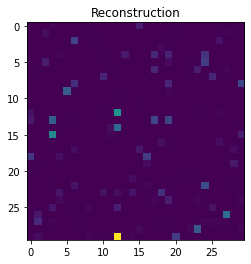

[[9.65986406e+04 8.16111069e+01 1.09803154e+02 2.42364600e+06
  1.56526672e+05 6.63187408e+01 2.20424891e+05 4.54137230e+01
  1.52075422e+05 1.22499702e+02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.16429985e+02 0.00000000e+00 1.34804620e+07
  0.00000000e+00 8.09768143e+01 1.56617752e+02 1.73417191e+02
  1.02074312e+05 1.27519602e+05 0.00000000e+00 9.65153275e+01
  6.62536087e+01 7.99077969e+04 1.46350952e+02 8.96838989e+01
  2.74153250e+05 1.20002594e+02]
 [0.00000000e+00 4.60707054e+01 5.62094800e+06 3.86584702e+01
  7.73508301e+01 4.54683188e+05 0.00000000e+00 1.37460734e+05
  1.40443650e+06 2.14774265e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 7.09722290e+01 0.00000000e+00 7.25707550e+01
  0.00000000e+00 5.16700516e+01 8.15447693e+01 1.58172875e+05
  1.37522338e+06 1.81762610e+03 1.15498329e+02 9.60038147e+01
  0.00000000e+00 0.00000000e+00 1.02780365e+02 1.35827225e+06
  9.19966500e+05 4.41840973e+01]
 [8.60435867e+01 1.34617453e+05 0.00000000e+00 0.00000000e+00
  9.

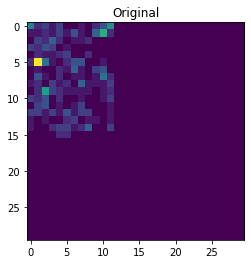

[[ 7  2  3  1  3  0  0  1  0  2  4  8  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 1  1  2  1  3  1  4  1  0  5 10  2  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  3  2  5  2  0  1  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 3  2  4  3  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  2  1  1  2  3  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 2 16  6  1  0  2  4  4  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  1  0  0  2  1  5  1  0  3  4  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  4  1  0  2  0  1  1  0  1  6  2  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 1  2  0  3  1  2  0  5  1  1  1  3  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  2  9  3  2  1  1  1  1  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 3  2  4  0  2  0  0  1  0  0  1  3  0  0  0  0 

In [10]:
    # Integrate through time for each location while displaying final image
    final_image = output[p_c][0].sum(0)
    plt.figure()
    plt.imshow(final_image.reshape((30, 30)))
    plt.title('Reconstruction')
    plt.show()

    print(final_image.reshape((30, 30)))

    input_image = train_data[0].sum(0)
    plt.figure()
    plt.imshow(input_image.reshape((30, 30)))
    plt.title('Original')
    plt.show()

    print(input_image.reshape((30, 30)))